# Calculating EOFs & PCs using the 'eofs' package

## Import the sst data from a netcdf file or multiple netcdf files

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from eofs.standard import Eof
%matplotlib inline
from glob import glob
import os
#import warnings
#warnings.simplefilter("ignore") 

## load the SST data from files using xarray

In [2]:
dir_base = '/home/pangeo/data/ersst/'
#!ls /home/pangeo/data/ersst/
! ulimit -n 
monthly_files = sorted(glob(os.path.join(dir_base, 'ersst.*.nc')))
num_files = np.shape(monthly_files)[0]; print(num_files)
# we can't open all of the files at once since we are only allowd 1024 open files
# dset = xr.open_mfdataset(monthly_files)

1024
1416


In [3]:
ds = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/\
                       .version4/.anom/T/-23.5/last/RANGE/dods',decode_times=False)

ds['T'] = pd.date_range('1/1/1958', periods=ds.anom.shape[0], freq='MS').shift(15, freq='D')
ds

<xarray.Dataset>
Dimensions:  (T: 723, X: 180, Y: 89, zlev: 1)
Coordinates:
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * zlev     (zlev) float32 0.0
  * Y        (Y) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * T        (T) datetime64[ns] 1958-01-16 1958-02-16 1958-03-16 1958-04-16 ...
Data variables:
    anom     (T, zlev, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [4]:
ds2 = ds.drop(['zlev']).squeeze().sel(T=slice('1958-01-01','2014-12-01'))

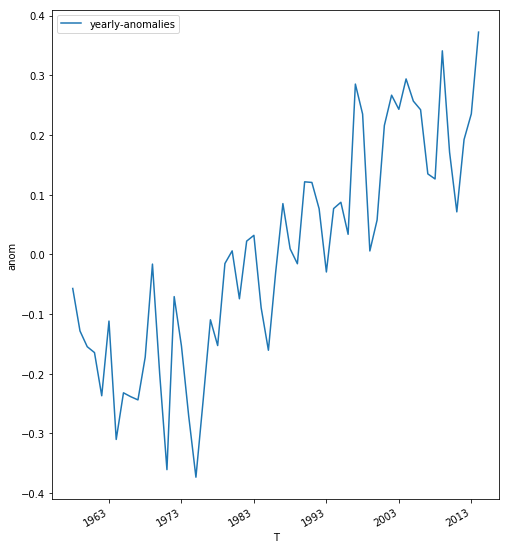

In [5]:
dpac = ds2.sel(Y=slice(-40,40), X=slice(120,290))
ds_annual = dpac.resample(T='AS').mean(dim='T')
ds_anom = ds_annual - ds_annual.mean(dim='T')

plt.figure(figsize=(8, 10))
#dpac.anom.mean(dim=['X','Y']).plot(label="monthly ssta")
#ds_annual.anom.mean(dim=['X','Y']).plot(label="annual means")
ds_anom.anom.mean(dim=['X','Y']).plot(label="yearly-anomalies")
plt.legend()

### define weights

In [6]:
coslat = np.cos(np.deg2rad(dpac.Y))
ds_anom['wgts'] = np.sqrt(coslat)+ 0*dpac.X
#or use .newaxis to make the right dimensions... but xarray can do the broadcasting right. 

### instantiates the EOF solver, passing the weights array as an optional argument

In [7]:
Eof?

Init signature: Eof(dataset, weights=None, center=True, ddof=1)
Docstring:      EOF analysis (`numpy` interface)
Init docstring:
Create an Eof object.

The EOF solution is computed at initialization time. Method
calls are used to retrieve computed quantities.

**Arguments:**

*dataset*
    A `numpy.ndarray` or `numpy.ma.MaskedArray` with two or more
    dimensions containing the data to be analysed. The first
    dimension is assumed to represent time. Missing values are
    permitted, either in the form of a masked array, or
    `numpy.nan` values. Missing values must be constant with time
    (e.g., values of an oceanographic field over land).

**Optional arguments:**

*weights*
    An array of weights whose shape is compatible with those of
    the input array *dataset*. The weights can have the same
    shape as *dataset* or a shape compatible with an array
    broadcast (i.e., the shape of the weights can can match the
    rightmost parts of the shape of the input array *dataset*)

In [10]:
solver = Eof(ds_anom.anom.values, weights=ds_anom.wgts.values)
solver

### get the EOFs (spatial patterns) as correlations

In [12]:
number_of_eofs = 4
Ss = solver.eofsAsCovariance(neofs=number_of_eofs)
#Ss = solver.eofsAsCorrelation(neofs=number_of_eofs)
ds_anom['ev'] = np.arange(0,number_of_eofs)
ds_anom['Ss'] = (['ev','Y','X'],Ss)

### get the Principal Components (PCs), normalized values

In [13]:
Ts = solver.pcs(npcs=number_of_eofs, pcscaling=1)
ds_anom['Ts'] = (['ev','T'],Ts.T)

### plots 

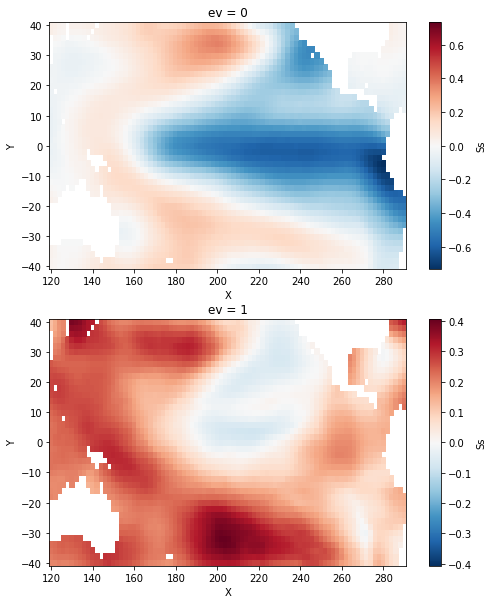

In [14]:
plt.figure(figsize=(8, 10))
plt.subplot(211)
ds_anom.Ss[0].plot()
plt.subplot(212)
ds_anom.Ss[1].plot()

Text(0.5,1,'PC2')

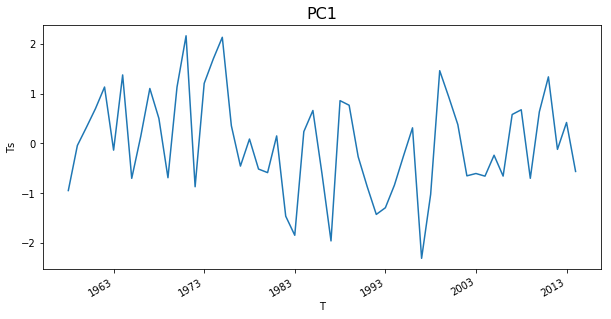

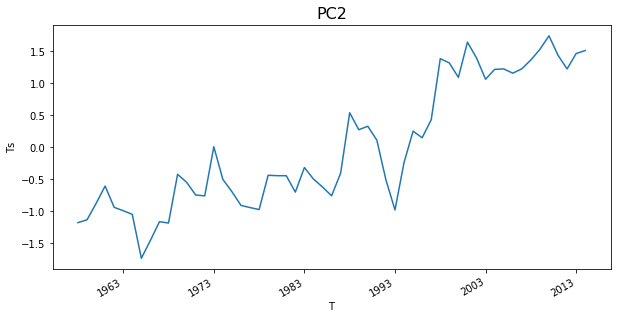

In [15]:
ds_anom.Ts[0].plot(figsize=(10,5)); plt.title('PC1',fontsize=16)
ds_anom.Ts[1].plot(figsize=(10,5)); plt.title('PC2',fontsize=16)

In [19]:
ds_anom.to_netcdf('python_EOF.nc', encoding={'T':{'dtype':'float32'}})
# encoding without integer makes it readable by ingrid and ncview

PermissionError: [Errno 13] Permission denied: b'/home/home2/biasutti/notebooks/python_EOF.nc'

<xarray.DataArray 'X' (X: 86)>
array([120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140., 142.,
       144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
       168., 170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
       192., 194., 196., 198., 200., 202., 204., 206., 208., 210., 212., 214.,
       216., 218., 220., 222., 224., 226., 228., 230., 232., 234., 236., 238.,
       240., 242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
       288., 290.], dtype=float32)
Coordinates:
  * X        (X) float32 120.0 122.0 124.0 126.0 128.0 130.0 132.0 134.0 ...
Attributes:
    long_name:      longitude
    pointwidth:     2.0
    standard_name:  longitude
    gridtype:       1
    units:          degree_east

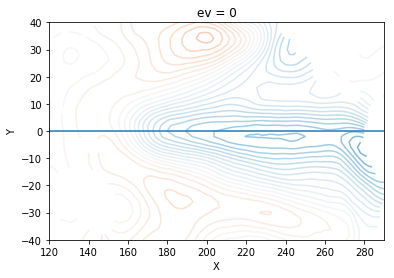

In [17]:
ds_anom.Ss[0].plot.contour(levels=np.arange(-1.5,1.5,.05))
plt.plot(ds_anom.X,0*ds_anom.X)
ds_anom.X